# DATA preprocess

In [ ]:
pip install pydot graphviz

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.utils import class_weight
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV

import tensorflow as tf
from tensorflow.keras import layers, models, initializers, regularizers, callbacks
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model

from itertools import cycle, product
from scipy import interp


In [ ]:
#test
LAB_file = 'https://raw.githubusercontent.com/shtthfkup/Python-programming-in-medical-data-analysis/main/shared_data/test.csv'
BA_file = 'https://raw.githubusercontent.com/shtthfkup/Python-programming-in-medical-data-analysis/main/shared_data/test_ba.csv'
US_file = 'https://raw.githubusercontent.com/shtthfkup/Python-programming-in-medical-data-analysis/main/shared_data/test_us.csv'
EMR_file = 'https://raw.githubusercontent.com/shtthfkup/Python-programming-in-medical-data-analysis/main/shared_data/test_emr.csv'

In [ ]:
df_LAB = pd.read_csv(LAB_file)
df_BA = pd.read_csv(BA_file)
df_US = pd.read_csv(US_file)
df_EMR = pd.read_csv(EMR_file)

In [ ]:
df_LAB["data_class"] = "LAB"
df_BA["data_class"] = "BA"
df_US["data_class"] = "US"
df_EMR["data_class"] = "EMR"

In [ ]:
merged_df = pd.concat([df_LAB, df_BA, df_US, df_EMR], axis=0)
merged_df.reset_index(drop=True, inplace=True)

In [ ]:
merged_df['LH_log'] = merged_df['LH'].apply(np.log)
merged_df['FSH_log'] = merged_df['FSH'].apply(np.log)
merged_df['IGF-1_log'] = merged_df['IGF-1'].apply(np.log)
merged_df['GH_log'] = merged_df['GH'].apply(np.log)
merged_df['TTE_log'] = merged_df['TTE'].apply(np.log)
merged_df['PRL_log'] = merged_df['PRL'].apply(np.log)
merged_df['E2_log'] = merged_df['E2'].apply(np.log)

In [ ]:
merged_df['BMI'] = merged_df['height']**2/merged_df['weight']
merged_df['Bone_age_diff'] = merged_df['BoneAge'] - merged_df['Age']
merged_df['uterus_vol'] = merged_df['uterus1'] * merged_df['uterus2'] * merged_df['uterus3']
merged_df['lovary_vol'] = merged_df['lovary1'] * merged_df['lovary2'] * merged_df['lovary3']
merged_df['rovary_vol'] = merged_df['rovary1'] * merged_df['rovary2'] * merged_df['rovary3']

In [ ]:
numeric_cols = merged_df.select_dtypes(include=np.number)
min_vals = numeric_cols.min()
max_vals = numeric_cols.max()
normalized_df = (numeric_cols - min_vals) / (max_vals - min_vals)
normalized_df = pd.concat([normalized_df, merged_df["data_class"]], axis=1)

In [ ]:
df = normalized_df.fillna(-1)
df

,LH,FSH,IGF-1,IGFBP-3,GH,TTE,PRL,E2,Age,IS_CPP,...,GH_log,TTE_log,PRL_log,E2_log,BMI,Bone_age_diff,uterus_vol,lovary_vol,rovary_vol,data_class
0,0.000000,0.019212,0.331692,0.332903,0.098887,0.00547,0.079051,0.018136,1.000000,0.0,...,0.643265,0.084972,0.499586,0.125554,-1.000000,-1.0,-1.0,-1.0,-1.0,LAB
1,0.000000,0.217099,-1.000000,-1.000000,-1.000000,0.00547,0.015798,0.068295,0.571429,0.0,...,-1.000000,0.084972,0.231813,0.323142,-1.000000,-1.0,-1.0,-1.0,-1.0,LAB
2,0.002328,0.378482,0.175784,0.224516,0.007631,0.02735,0.030657,0.087087,0.571429,0.0,...,0.272717,0.268320,0.332514,0.372534,-1.000000,-1.0,-1.0,-1.0,-1.0,LAB
3,0.000000,0.170029,0.135667,0.221935,0.079491,0.00547,0.019498,0.013451,1.000000,0.0,...,0.609990,0.084972,0.261907,0.097924,-1.000000,-1.0,-1.0,-1.0,-1.0,LAB
4,0.000000,0.067243,0.288840,0.321290,0.051510,0.03083,0.010102,0.022742,1.000000,1.0,...,0.544323,0.287441,0.174540,0.150393,-1.000000,-1.0,-1.0,-1.0,-1.0,LAB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7812,0.010477,0.386167,0.163931,0.272258,0.596184,0.00000,0.013684,0.005840,1.000000,1.0,...,0.919927,0.000000,0.212385,0.046581,0.605401,-1.0,-1.0,-1.0,-1.0,EMR
7813,0.000000,0.168108,0.144785,0.294839,-1.000000,0.00000,-1.000000,-1.000000,0.857143,0.0,...,-1.000000,0.000000,-1.000000,-1.000000,0.852973,-1.0,-1.0,-1.0,-1.0,EMR
7814,0.006985,0.142171,0.213166,0.258710,0.005087,-1.00000,0.041581,0.024467,1.000000,1.0,...,0.222641,-1.000000,0.383881,0.159180,0.413286,-1.0,-1.0,-1.0,-1.0,EMR
7815,0.000000,0.073007,0.137491,0.285161,0.024483,0.00547,0.054619,0.008189,0.857143,0.0,...,0.433975,0.084972,0.431938,0.063414,0.419081,-1.0,-1.0,-1.0,-1.0,EMR


In [ ]:
df_columns = df.columns
df_columns

Index(['LH', 'FSH', 'IGF-1', 'IGFBP-3', 'GH', 'TTE', 'PRL', 'E2', 'Age',
       'IS_CPP', 'BoneAge', 'Age_ratio', 'uterus1', 'uterus2', 'uterus3',
       'lovary1', 'lovary2', 'lovary3', 'rovary1', 'rovary2', 'rovary3',
       'abnormal', 'height', 'weight', 'breast', 'core', 'vulva', 'pubes',
       'pigmentation', 'LH_log', 'FSH_log', 'IGF-1_log', 'GH_log', 'TTE_log',
       'PRL_log', 'E2_log', 'BMI', 'Bone_age_diff', 'uterus_vol', 'lovary_vol',
       'rovary_vol', 'data_class'],
      dtype='object')

# data_split

In [ ]:
def data_spilt(X,y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = data_spilt(X,y)

# predict function

In [ ]:
def predict_accuracy(model,X_test,y_test):
  y_pred = model.predict(X_test)
  # 计算模型的准确率
  accuracy = accuracy_score(y_test, y_pred)
  print(""+" Accuracy:", accuracy)

# SVM

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

hormone = ['LH_log','FSH_log','IGF-1_log','GH_log','TTE_log','PRL_log','E2_log','LH','FSH','IGF-1','GH','TTE','PRL','E2']

for h in hormone:

  filt_df = df[df[h] != -1]

# 提取特征矩阵 X 和目标向量 y
  X = filt_df[[h, 'Age']].values
  y = filt_df['IS_CPP'].values


# 将数据集分为训练集和测试集
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 创建 SVM 模型
  svm_model = SVC()
  svm_model = SVC(class_weight='balanced')

# 在训练集上训练模型
  svm_model.fit(X_train, y_train)

# 在测试集上进行预测
  y_pred = svm_model.predict(X_test)

  # 计算模型的准确率
  accuracy = accuracy_score(y_test, y_pred)
  print(h+" Accuracy:", accuracy)

LH_log Accuracy: 0.808
FSH_log Accuracy: 0.6712727272727272
IGF-1_log Accuracy: 0.7113970588235294
GH_log Accuracy: 0.6388384754990926
TTE_log Accuracy: 0.6428571428571429
PRL_log Accuracy: 0.6479250334672021
E2_log Accuracy: 0.6774193548387096
LH Accuracy: 0.76
FSH Accuracy: 0.6836363636363636
IGF-1 Accuracy: 0.7159926470588235
GH Accuracy: 0.6197822141560798
TTE Accuracy: 0.6341463414634146
PRL Accuracy: 0.6519410977242303
E2 Accuracy: 0.6601382488479263


In [ ]:
def LH_log_SVM_(df):
    filt_df = df[df["LH_log"] != -1]

    # 提取特征矩阵 X 和目标向量 y
    X = filt_df[['LH_log', 'Age']].values
    y = filt_df['IS_CPP'].values


    # 将数据集分为训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 创建 SVM 模型
    svm_model_LH_ = SVC()
    svm_model = SVC(class_weight='balanced')

    # 在训练集上训练模型
    svm_model.fit(X_train, y_train)

    return svm_model

In [ ]:
def LH_log_To_Age_SVM(df):
    feature_columns = ['LH_log']
    filt_df = df[df["data_class"] == ""]
    X = filt_df[['LH_log', 'Age']].values
    y = filt_df['IS_CPP'].values

    svm_model_LH_log = SVC()
    svm_model_LH_log = SVC(class_weight='balanced')
    # 在训练集上训练模型
    svm_model.fit(X_train, y_train)

    return svm_model

LH_log Accuracy: 0.808


In [ ]:
X = df[['LH_log', 'Age']].values
y = df['IS_CPP'].values

X_train, X_test, y_train, y_test = data_spilt(X,y)

def Calibrated_SVM_LH_log(X_train,y_train):
    svm_model_ = SVC(kernel='rbf', C=30, class_weight='balanced', probability=True)
    svm_model.fit(X_train, y_train)

    # 使用 CalibratedClassifierCV 进行概率校准
    calibrated_svc = CalibratedClassifierCV(svm_model, method='sigmoid', cv='prefit')
    calibrated_svc.fit(X_train, y_train)

    return calibrated_svc


trained_model_Calibrated_SVM_LH_log = Calibrated_SVM_LH_log(X_train=X_train,y_train=y_train)

y_pred_proba = trained_model_Calibrated_SVM_LH_log.predict_proba(X_test)
y_pred = trained_model_Calibrated_SVM_LH_log.predict(X_test)

# 计算模型的准确率
accuracy = accuracy_score(y_test, y_pred)
print("Calibrated_SVM_LH_log"+" Accuracy:", accuracy)

Calibrated_SVM_LH_log Accuracy: 0.7883631713554987


In [ ]:
X = df[['LH_log', 'Age']].values
y = df['IS_CPP'].values

X_train, X_test, y_train, y_test = data_spilt(X,y)

def Calibrated_SVM_LH_log(X_train,y_train):
    svm_model_ = SVC(kernel='rbf', class_weight='balanced', probability=True)
    svm_model.fit(X_train, y_train)

    # 使用 CalibratedClassifierCV 进行概率校准
    calibrated_svc = CalibratedClassifierCV(svm_model, method='isotonic', cv='prefit')
    calibrated_svc.fit(X_train, y_train)

    return calibrated_svc


trained_model_Calibrated_SVM_LH_log = Calibrated_SVM_LH_log(X_train=X_train,y_train=y_train)

y_pred_proba = trained_model_Calibrated_SVM_LH_log.predict_proba(X_test)
y_pred_proba=y_pred_proba[:,1]
y_pred = trained_model_Calibrated_SVM_LH_log.predict(X_test)

# 计算模型的准确率
accuracy = accuracy_score(y_test, y_pred)
print("Calibrated_SVM_LH_log"+" Accuracy:", accuracy)

Calibrated_SVM_LH_log Accuracy: 0.7979539641943734


In [ ]:
y_pred_proba=y_pred_proba[:,1]
print(y_pred_proba,y_pred)

[0.58986175 0.63414634 0.58986175 ... 0.9939759  0.05420054 0.90369898] [1. 1. 1. ... 1. 0. 1.]


[:, 0] 表示样本属于类别 0 的概率。
[:, 1] 表示样本属于类别 1 的概率。

In [ ]:
def build_svm_model(df):
  return model

# DNN Model

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

In [ ]:
# 构建模型
def build_model(feature_num, num_classes):
    inputs = layers.Input(shape=(feature_num, ), name="feats")
    x = layers.Dense(64, activation="relu")(inputs)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(32, activation="sigmoid")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(64, activation="relu")(x)

    logits = layers.Dense(num_classes, name="logits")(x)
    model = models.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
# 构建模型
def build_model_2(feature_num, num_classes):
    inputs = layers.Input(shape=(feature_num, ), name="feats")
    x = layers.Dense(64, activation="relu")(inputs)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(32, activation="sigmoid")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(64, activation="sigmoid")(inputs)

    logits = layers.Dense(num_classes, name="logits")(x)
    model = models.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
def build_model_3(feature_num, num_classes, X_train, y_train):
    # 使用逐步回归选择特征
    selector = SequentialFeatureSelector(LinearRegression(), n_features_to_select=feature_num, direction='forward')
    selector.fit(X_train, y_train)

    # 获取选择的特征索引
    selected_features_idx = selector.get_support(indices=True)

    # 构建模型
    inputs = layers.Input(shape=(feature_num, ), name="feats")
    x = layers.Dense(8, activation="relu")(inputs)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(32, activation="sigmoid")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(64, activation="softmax")(inputs)

    # 仅使用选择的特征
    x = layers.Concatenate()([x[:, i] for i in selected_features_idx])

    logits = layers.Dense(num_classes, name="logits")(x)
    model = models.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
def build_model_4(feature_num,X_train, y_train):
    # 使用逐步回归选择特征
    selector = SequentialFeatureSelector(LinearRegression(), n_features_to_select=len(feature_num), direction='forward')
    selector.fit(X_train, y_train)

    # 获取选择的特征索引
    selected_features_idx = selector.get_support(indices=True)

    # 构建模型
    inputs = layers.Input(shape=(len(feature_columns), ), name="feats")
    x = layers.Dense(32, activation="relu")(inputs)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(32, activation="sigmoid")(inputs)
    logits = layers.Dense(1, name="logits")(x)

    model = models.Model(inputs=inputs, outputs=logits)
    return model


In [ ]:
# 构建模型
def build_model_5(feature_num, num_classes):
    inputs = layers.Input(shape=(feature_num, ), name="feats")
    x = layers.Dense(128, activation="relu")(inputs)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(64, activation="sigmoid")(x)
    x = layers.Dropout(0.1)(x)

    logits = layers.Dense(num_classes, name="logits")(x)
    model = models.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
# 构建模型
def build_model_6(feature_num, num_classes):
    inputs = layers.Input(shape=(feature_num, ), name="feats")
    x = layers.Dense(128, activation="relu")(inputs)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(64, activation="sigmoid")(x)
    x = layers.Dropout(0.1)(x)

    logits = layers.Dense(num_classes, name="logits")(x)
    model = models.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
# 构建模型
def build_model_7(feature_num, num_classes):
    inputs = layers.Input(shape=(feature_num, ), name="feats")
    x = layers.Dense(128, activation="relu")(inputs)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(32, activation="sigmoid")(x)

    logits = layers.Dense(num_classes, name="logits")(x)
    model = models.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
def build_model_9(feature_columns,X_train, y_train):
    # 使用逐步回归选择特征
    # 使用逐步回归选择特征，选择总特征数量的一半
    n_features_to_select = len(feature_columns) // 2
    selector = SequentialFeatureSelector(LinearRegression(), n_features_to_select=n_features_to_select, direction='forward')
    selector.fit(X_train, y_train)

    # 获取选择的特征索引
    selected_features_idx = selector.get_support(indices=True)

    # 获取选择的特征索引
    selected_features_idx = selector.get_support(indices=True)

    # 构建模型
    inputs = layers.Input(shape=(len(feature_columns), ), name="feats")
    x = layers.Dense(128, activation="relu")(inputs)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(64, activation="sigmoid")(x)


        # 仅使用选择的特征
    selected_features = [layers.Lambda(lambda x, i=i: x[:, i:i+1])(x) for i in selected_features_idx]
    x = layers.Concatenate()(selected_features)

    logits = layers.Dense(1, activation='sigmoid', name="logits")(x)  # 因为是二分类问题，所以用 sigmoid
    model = models.Model(inputs=inputs, outputs=logits)
    return model
    return model

In [ ]:
def build_model_10(feature_columns):
    feature_num = len(feature_columns)

    # 输入层
    inputs = layers.Input(shape=(feature_num,), name="feats")

    # 可训练的权重向量
    feature_weights = layers.Dense(feature_num, activation='sigmoid', use_bias=False,
                                   kernel_initializer=initializers.Ones(), name="feature_weights")

    # 权重化输入特征
    weighted_inputs = layers.Multiply()([inputs, feature_weights(inputs)])

    # 后续的全连接层，增加正则化项
    x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.001))(weighted_inputs)
    x = layers.Dropout(0.15)(x)  # 增加Dropout率
    x = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.Dropout(0.15)(x)  # 增加Dropout率
    x = layers.Dense(32, activation="sigmoid", kernel_regularizer=regularizers.l2(0.001))(x)

    # 输出层
    logits = layers.Dense(1, activation='sigmoid', name="logits")(x)  # 因为是二分类问题，所以用 sigmoid
    model = models.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
def build_model_11(feature_columns):
    feature_num = len(feature_columns)

    # 输入层
    inputs = layers.Input(shape=(feature_num,), name="feats")

    # 可训练的权重向量
    feature_weights = layers.Dense(feature_num, activation='sigmoid', use_bias=False,
                                   kernel_initializer=initializers.Ones(), name="feature_weights")

    # 权重化输入特征
    weighted_inputs = layers.Multiply()([inputs, feature_weights(inputs)])

    # 后续的全连接层，增加正则化项
    x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.001))(weighted_inputs)
    x = layers.Dropout(0.5)(x)  # 增加Dropout率
    x = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.004))(x)
    x = layers.Dropout(0.3)(x)  # 增加Dropout率
    x = layers.Dense(64, activation="sigmoid", kernel_regularizer=regularizers.l2(0.002))(x)

    # 输出层
    logits = layers.Dense(1, activation='sigmoid', name="logits")(x)  # 因为是二分类问题，所以用 sigmoid
    model = models.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
def build_model_12(feature_columns):
    feature_num = len(feature_columns)

    # 输入层
    inputs = layers.Input(shape=(feature_num,), name="feats")

    # 可训练的权重向量
    feature_weights = layers.Dense(feature_num, activation='sigmoid', use_bias=False,
                                   kernel_initializer=initializers.Ones(), name="feature_weights")

    # 权重化输入特征
    weighted_inputs = layers.Multiply()([inputs, feature_weights(inputs)])

    # 后续的全连接层，增加正则化项
    x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.001))(weighted_inputs)
    x = layers.Dropout(0.5)(x)  # 增加Dropout率
    x = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.004))(x)
    x = layers.Dropout(0.3)(x)  # 增加Dropout率
    x = layers.Dense(64, activation="sigmoid", kernel_regularizer=regularizers.l2(0.002))(x)

    # 输出层
    logits = layers.Dense(1, activation='sigmoid', name="logits")(x)  # 因为是二分类问题，所以用 sigmoid
    model = models.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
model = build_model_11(feature_columns=feature_columns)

# 编译模型
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 训练模型
model.fit(X_train, y_train, batch_size=8, epochs=200, validation_split=0.2)

# 在测试集上进行预测
y_pred = model.predict(X_test)
---------
# 将概率转换为类别（这里假设阈值为0.5）
y_pred_class = np.where(y_pred >= 0.5, 1, 0)

# 计算模型的准确率
accuracy = accuracy_score(y_test, y_pred_class)
print("Accuracy:", accuracy)

# 计算混淆矩阵
conf_matrix = confusion_matrix(y_test, y_pred_class)
print("Confusion Matrix:\n", conf_matrix)

In [ ]:
    elif df["data_class"] == "EMR":
        y_pred_model_1 = model_1.predict(df)
        y_pred_model_4 = model_4.predict(df)
        y_pred_ensemble = np.logical_or(y_pred_model_1, y_pred_model_4)

# SVM_model_training

In [ ]:
def Calibrated_SVM_LH_log(X_train,y_train):
    svm_model_ = SVC(kernel='rbf', class_weight='balanced', probability=True)
    svm_model.fit(X_train, y_train)

    # 使用 CalibratedClassifierCV 进行概率校准
    calibrated_svc = CalibratedClassifierCV(svm_model, method='isotonic', cv='prefit')
    calibrated_svc.fit(X_train, y_train)

    return calibrated_svc

Calibrated_SVM_LH_log Accuracy: 0.7979539641943734
[0.58986175 0.63414634 0.58986175 ... 0.9939759  0.05420054 0.90369898] [1. 1. 1. ... 1. 0. 1.]


In [ ]:
feature_columns_SVM = ['LH_log', 'Age']
target_columns = ["IS_CPP"]

X = df[feature_columns].values
y = df[target_columns].values

X_train, X_test, y_train, y_test = data_spilt(X,y)

#model 產生
trained_model_Calibrated_SVM_LH_log = Calibrated_SVM_LH_log(X_train=X_train,y_train=y_train)

#預測結果機率矩陣
y_pred_proba = trained_model_Calibrated_SVM_LH_log.predict_proba(X_test)
y_pred_proba=y_pred_proba[:,1]
y_pred = trained_model_Calibrated_SVM_LH_log.predict(X_test)

print(y_pred_proba,y_pred)

#計算accuracy
y_pred_binary = (y_pred_proba > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
print("Calibrated_SVM_LH_log"+" Accuracy:", accuracy)

# DNN_LAB_model_training

In [ ]:
def DNN_model_LAB(df,feature_columns=feature_columns_LAB):
    feature_num = len(feature_columns)
    inputs = layers.Input(shape=(feature_num,), name="feats")

    # 可训练的权重向量
    feature_weights = layers.Dense(feature_num, activation='sigmoid', use_bias=False,
                                   kernel_initializer=initializers.Ones(), name="feature_weights")
    # 权重化输入特征
    weighted_inputs = layers.Multiply()([inputs, feature_weights(inputs)])

    # 后续的全连接层，增加正则化项
    x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.001))(weighted_inputs)
    x = layers.Dropout(0.5)(x)  # 增加Dropout率
    x = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.004))(x)
    x = layers.Dropout(0.3)(x)  # 增加Dropout率
    x = layers.Dense(64, activation="sigmoid", kernel_regularizer=regularizers.l2(0.002))(x)

    # 输出层
    logits = layers.Dense(1, activation='sigmoid', name="logits")(x)  # 因为是二分类问题，所以用 sigmoid
    model = models.Model(inputs=inputs, outputs=logits)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, batch_size=8, epochs=200, validation_split=0.2)
    return model

In [ ]:
#篩選輸入資料
feature_columns_LAB = ["LH_log","Age", "LH","FSH","IGF-1","IGFBP-3","GH","TTE","PRL","E2"]

target_columns = ["IS_CPP"]

In [ ]:
filt_df_LAB = df[df["data_class"] == "LAB"]

X = filt_df_LAB[feature_columns_LAB].values
y = filt_df_LAB[target_columns].values

X_train, X_test, y_train, y_test = data_spilt(X,y)

#model 產生
trained_model_DNN_LAB = DNN_model_LAB(df=filt_df_LAB)

#預測結果機率矩陣
y_pred_DNN_LAB = trained_model_DNN_LAB.predict(X_test)
y_pred_DNN_LAB=y_pred_DNN_LAB[:,0]

print(y_pred_DNN_LAB)

#計算accuracy
y_pred_binary = (y_pred_DNN_LAB > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred_binary)
print("DNN_LAB"+" Accuracy:", accuracy)

Epoch 1/200
202/202 [==============================] - 2s 6ms/step - loss: 0.8342 - accuracy: 0.6196 - val_loss: 0.6554 - val_accuracy: 0.7376
Epoch 2/200
202/202 [==============================] - 1s 5ms/step - loss: 0.5993 - accuracy: 0.7553 - val_loss: 0.5465 - val_accuracy: 0.7995
Epoch 3/200
202/202 [==============================] - 1s 5ms/step - loss: 0.5534 - accuracy: 0.7838 - val_loss: 0.5241 - val_accuracy: 0.7896
Epoch 4/200
202/202 [==============================] - 1s 4ms/step - loss: 0.5394 - accuracy: 0.7906 - val_loss: 0.5057 - val_accuracy: 0.8069
Epoch 5/200
202/202 [==============================] - 1s 3ms/step - loss: 0.5276 - accuracy: 0.7918 - val_loss: 0.4989 - val_accuracy: 0.8069
Epoch 6/200
202/202 [==============================] - 1s 3ms/step - loss: 0.5286 - accuracy: 0.7918 - val_loss: 0.4940 - val_accuracy: 0.8020
Epoch 7/200
202/202 [==============================] - 1s 3ms/step - loss: 0.5118 - accuracy: 0.8030 - val_loss: 0.4996 - val_accuracy: 0.8218

# DNN_US_model_training

In [ ]:
def DNN_model_US(df,feature_columns=feature_columns_US):
    feature_num = len(feature_columns)
    inputs = layers.Input(shape=(feature_num,), name="feats")

    # 可训练的权重向量
    feature_weights = layers.Dense(feature_num, activation='sigmoid', use_bias=False,
                                   kernel_initializer=initializers.Ones(), name="feature_weights")
    # 权重化输入特征
    weighted_inputs = layers.Multiply()([inputs, feature_weights(inputs)])

    # 后续的全连接层，增加正则化项
    x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.001))(weighted_inputs)
    x = layers.Dropout(0.5)(x)  # 增加Dropout率
    x = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.004))(x)
    x = layers.Dropout(0.3)(x)  # 增加Dropout率
    x = layers.Dense(64, activation="sigmoid", kernel_regularizer=regularizers.l2(0.002))(x)

    # 输出层
    logits = layers.Dense(1, activation='sigmoid', name="logits")(x)  # 因为是二分类问题，所以用 sigmoid
    model = models.Model(inputs=inputs, outputs=logits)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, batch_size=8, epochs=200, validation_split=0.2)
    return model

In [ ]:
feature_columns_US = ["LH_log","Age", "uterus_vol", "lovary_vol", "rovary_vol",
                   "uterus1", "uterus2", "uterus3",
                   "lovary1", "lovary2", "lovary3",
                   "rovary1", "rovary2", "rovary3",
                   "LH","FSH","IGF-1","IGFBP-3","GH","TTE","PRL","E2"]
target_columns = ["IS_CPP"]

In [ ]:
filt_df_US = df[df["data_class"] == "US"]

X = filt_df_US[feature_columns].values
y = filt_df_US[target_columns].values

X_train, X_test, y_train, y_test = data_spilt(X,y)

#model 產生
trained_model_DNN_US = DNN_model_US(df=filt_df_US)

#預測結果機率矩陣
y_pred_DNN_US = trained_model_DNN_US.predict(X_test)
y_pred_DNN_US=y_pred_DNN_US[:,0]

print(y_pred_DNN_US)

#計算accuracy
y_pred_binary = (y_pred_DNN_US > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred_binary)
print("DNN_US"+" Accuracy:", accuracy)

# DNN_BA_model_training

In [ ]:
def DNN_model_BA(df,feature_columns=feature_columns_BA):
    feature_num = len(feature_columns)
    inputs = layers.Input(shape=(feature_num,), name="feats")

    # 可训练的权重向量
    feature_weights = layers.Dense(feature_num, activation='sigmoid', use_bias=False,
                                   kernel_initializer=initializers.Ones(), name="feature_weights")
    # 权重化输入特征
    weighted_inputs = layers.Multiply()([inputs, feature_weights(inputs)])

    # 后续的全连接层，增加正则化项
    x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.001))(weighted_inputs)
    x = layers.Dropout(0.5)(x)  # 增加Dropout率
    x = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.004))(x)
    x = layers.Dropout(0.3)(x)  # 增加Dropout率
    x = layers.Dense(64, activation="sigmoid", kernel_regularizer=regularizers.l2(0.002))(x)

    # 输出层
    logits = layers.Dense(1, activation='sigmoid', name="logits")(x)  # 因为是二分类问题，所以用 sigmoid
    model = models.Model(inputs=inputs, outputs=logits)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, batch_size=8, epochs=200, validation_split=0.2)
    return model

In [ ]:
#篩選輸入資料
feature_columns_BA = ["LH_log","Age", "BoneAge", "Bone_age_diff", "Age_ratio",
                                     "LH","FSH","IGF-1","IGFBP-3","GH","TTE","PRL","E2"]

target_columns = ["IS_CPP"]

In [ ]:
filt_df_US = df[df["data_class"] == "BA"]

X = filt_df_US[feature_columns].values
y = filt_df_US[target_columns].values

X_train, X_test, y_train, y_test = data_spilt(X,y)

#model 產生
trained_model_DNN_BA = DNN_model_BA(df=filt_df_US)

#預測結果機率矩陣
y_pred_DNN_BA = trained_model_DNN_BA.predict(X_test)
y_pred_DNN_BA=y_pred_DNN_BA[:,0]

print(y_pred_DNN_BA)

#計算accuracy
y_pred_binary = (y_pred_DNN_BA > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred_binary)
print("DNN_BA"+" Accuracy:", accuracy)

# DNN_EMR_model_training

In [ ]:
def DNN_model_EMR(df,feature_columns=feature_columns_EMR):
    feature_num = len(feature_columns)
    inputs = layers.Input(shape=(feature_num,), name="feats")

    # 可训练的权重向量
    feature_weights = layers.Dense(feature_num, activation='sigmoid', use_bias=False,
                                   kernel_initializer=initializers.Ones(), name="feature_weights")
    # 权重化输入特征
    weighted_inputs = layers.Multiply()([inputs, feature_weights(inputs)])

    # 后续的全连接层，增加正则化项
    x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.001))(weighted_inputs)
    x = layers.Dropout(0.5)(x)  # 增加Dropout率
    x = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.004))(x)
    x = layers.Dropout(0.3)(x)  # 增加Dropout率
    x = layers.Dense(64, activation="sigmoid", kernel_regularizer=regularizers.l2(0.002))(x)

    # 输出层
    logits = layers.Dense(1, activation='sigmoid', name="logits")(x)  # 因为是二分类问题，所以用 sigmoid
    model = models.Model(inputs=inputs, outputs=logits)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, batch_size=8, epochs=200, validation_split=0.2)
    return model

In [ ]:
#篩選輸入資料
feature_columns_EMR =  ["LH_log","Age", "abnormal", "breast", "core","vulva","pubes","pigmentation",
                    "LH","FSH","IGF-1","IGFBP-3","GH","TTE","PRL","E2"]

target_columns = ["IS_CPP"]

In [ ]:
filt_df_US = df[df["data_class"] == "EMR"]

X = filt_df_US[feature_columns].values
y = filt_df_US[target_columns].values

X_train, X_test, y_train, y_test = data_spilt(X,y)

#model 產生
trained_model_DNN_EMR = DNN_model_EMR(df=filt_df_US)

#預測結果機率矩陣
y_pred_DNN_EMR = trained_model_DNN_EMR.predict(X_test)
y_pred_DNN_EMR=y_pred_DNN_EMR[:,0]

print(y_pred_DNN_EMR)

#計算accuracy
y_pred_binary = (y_pred_DNN_EMR > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred_binary)
print("DNN_EMR"+" Accuracy:", accuracy)

# US

In [ ]:
feature_columns_US = ["LH_log","Age", "uterus_vol", "lovary_vol", "rovary_vol",
                   "uterus1", "uterus2", "uterus3",
                   "lovary1", "lovary2", "lovary3",
                   "rovary1", "rovary2", "rovary3",
                   "LH","FSH","IGF-1","IGFBP-3","GH","TTE","PRL","E2"]
target_columns = ["IS_CPP"]

In [ ]:
len(feature_columns_US)

22

In [ ]:
filt_df = df[df["uterus_vol"] != -1]
len(filt_df)

2007

In [ ]:
filt_df

,LH,FSH,IGF-1,IGFBP-3,GH,TTE,PRL,E2,Age,IS_CPP,...,IGF-1_log,GH_log,TTE_log,PRL_log,E2_log,BMI,Bone_age_diff,uterus_vol,lovary_vol,rovary_vol
3224,0.000000,0.035543,0.162108,0.369420,0.193005,-1.000000,0.032654,0.011656,1.000000,0.0,...,0.508295,0.745812,-1.000000,0.342922,0.057520,-1.0,-1.0,0.123867,0.093946,0.095830
3225,0.133877,0.324688,0.128373,-1.000000,0.006041,-1.000000,-1.000000,-1.000000,0.857143,1.0,...,0.452767,0.243358,-1.000000,-1.000000,-1.000000,-1.0,-1.0,0.281815,0.110908,0.163566
3226,0.090803,0.321806,0.348104,-1.000000,-1.000000,0.005470,-1.000000,-1.000000,1.000000,1.0,...,0.705151,-1.000000,0.084972,-1.000000,-1.000000,-1.0,-1.0,0.125652,0.198982,-1.000000
3227,0.000000,0.095101,0.248724,-1.000000,0.094436,0.025858,-1.000000,-1.000000,0.857143,0.0,...,0.616150,0.636234,0.259601,-1.000000,-1.000000,-1.0,-1.0,0.042962,0.030663,0.047863
3228,0.000000,0.157541,0.128373,-1.000000,0.075676,0.014421,-1.000000,-1.000000,0.714286,0.0,...,0.452767,0.602512,0.178424,-1.000000,-1.000000,-1.0,-1.0,0.036184,0.120694,0.054043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5226,0.000000,0.072046,0.244165,0.542411,0.177424,0.006464,-1.000000,-1.000000,0.857143,0.0,...,0.611352,0.732865,0.097488,-1.000000,-1.000000,-1.0,-1.0,0.068582,0.087422,0.137345
5227,0.274738,0.601345,0.462071,0.670759,0.256280,0.010940,-1.000000,-1.000000,1.000000,1.0,...,0.782376,0.789490,0.146522,-1.000000,-1.000000,-1.0,-1.0,0.169799,0.088466,0.106131
5228,0.002328,0.135447,-1.000000,0.415179,-1.000000,0.006464,-1.000000,-1.000000,1.000000,1.0,...,-1.000000,-1.000000,0.097488,-1.000000,-1.000000,-1.0,-1.0,0.166319,0.514092,0.323802
5229,0.149010,0.600384,0.289752,0.426339,0.001590,0.009448,0.030364,0.125427,1.000000,1.0,...,0.656171,0.107536,0.131333,0.330937,0.379817,-1.0,-1.0,0.070073,-1.000000,0.046198


US 1

In [ ]:
X = filt_df[feature_columns].values
y = filt_df[target_columns].values

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 初始化模型
model = build_model(feature_num=len(feature_columns), num_classes=1)

# 编译模型
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 训练模型
model.fit(X_train, y_train, batch_size=32, epochs=40, validation_split=0.2)

# 在测试集上进行预测
y_pred = model.predict(X_test)
# 将概率转换为类别（这里假设阈值为0.5）
y_pred_class = np.where(y_pred >= 0.5, 1, 0)

# 计算模型的准确率
accuracy = accuracy_score(y_test, y_pred_class)
print("Accuracy:", accuracy)

Epoch 1/40
41/41 [==============================] - 2s 13ms/step - loss: 0.8638 - accuracy: 0.5350 - val_loss: 0.6556 - val_accuracy: 0.5919
Epoch 2/40
41/41 [==============================] - 0s 6ms/step - loss: 0.6562 - accuracy: 0.6301 - val_loss: 0.6484 - val_accuracy: 0.6604
Epoch 3/40
41/41 [==============================] - 0s 3ms/step - loss: 0.6494 - accuracy: 0.6745 - val_loss: 0.6458 - val_accuracy: 0.6698
Epoch 4/40
41/41 [==============================] - 0s 3ms/step - loss: 0.6468 - accuracy: 0.6682 - val_loss: 0.6430 - val_accuracy: 0.6667
Epoch 5/40
41/41 [==============================] - 0s 3ms/step - loss: 0.6452 - accuracy: 0.6690 - val_loss: 0.6421 - val_accuracy: 0.6947
Epoch 6/40
41/41 [==============================] - 0s 3ms/step - loss: 0.6424 - accuracy: 0.6729 - val_loss: 0.6392 - val_accuracy: 0.6698
Epoch 7/40
41/41 [==============================] - 0s 3ms/step - loss: 0.6478 - accuracy: 0.6760 - val_loss: 0.6357 - val_accuracy: 0.6822
Epoch 8/40
41/41 [=

In [ ]:
X = filt_df[feature_columns].values
y = filt_df[target_columns].values

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 初始化模型
model = build_model_5(feature_num=len(feature_columns), num_classes=1)

# 编译模型
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 训练模型
model.fit(X_train, y_train, batch_size=8, epochs=200, validation_split=0.2)

# 在测试集上进行预测
y_pred = model.predict(X_test)
# 将概率转换为类别（这里假设阈值为0.5）
y_pred_class = np.where(y_pred >= 0.5, 1, 0)

# 计算模型的准确率
accuracy = accuracy_score(y_test, y_pred_class)
print("Accuracy:", accuracy)

Epoch 1/200
161/161 [==============================] - 2s 5ms/step - loss: 0.9655 - accuracy: 0.5312 - val_loss: 0.6776 - val_accuracy: 0.5389
Epoch 2/200
161/161 [==============================] - 1s 3ms/step - loss: 1.0172 - accuracy: 0.5164 - val_loss: 0.6741 - val_accuracy: 0.6417
Epoch 3/200
161/161 [==============================] - 1s 4ms/step - loss: 0.8538 - accuracy: 0.5397 - val_loss: 0.6617 - val_accuracy: 0.6044
Epoch 4/200
161/161 [==============================] - 1s 3ms/step - loss: 0.8506 - accuracy: 0.5382 - val_loss: 0.6581 - val_accuracy: 0.6417
Epoch 5/200
161/161 [==============================] - 1s 4ms/step - loss: 0.8399 - accuracy: 0.5288 - val_loss: 0.6637 - val_accuracy: 0.6168
Epoch 6/200
161/161 [==============================] - 1s 4ms/step - loss: 0.8124 - accuracy: 0.5475 - val_loss: 0.6462 - val_accuracy: 0.6480
Epoch 7/200
161/161 [==============================] - 1s 4ms/step - loss: 0.7419 - accuracy: 0.5654 - val_loss: 0.6343 - val_accuracy: 0.6667

US 3

In [ ]:
X = filt_df[feature_columns].values
y = filt_df[target_columns].values

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 初始化模型
model = build_model_6(feature_num=len(feature_columns), num_classes=1)

# 编译模型
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 训练模型
model.fit(X_train, y_train, batch_size=8, epochs=200, validation_split=0.2)

# 在测试集上进行预测
y_pred = model.predict(X_test)
# 将概率转换为类别（这里假设阈值为0.5）
y_pred_class = np.where(y_pred >= 0.5, 1, 0)

# 计算模型的准确率
accuracy = accuracy_score(y_test, y_pred_class)
print("Accuracy:", accuracy)

Epoch 1/200
161/161 [==============================] - 4s 8ms/step - loss: 1.4436 - accuracy: 0.4634 - val_loss: 0.6918 - val_accuracy: 0.5109
Epoch 2/200
161/161 [==============================] - 1s 8ms/step - loss: 1.0017 - accuracy: 0.5086 - val_loss: 0.8483 - val_accuracy: 0.4579
Epoch 3/200
161/161 [==============================] - 1s 5ms/step - loss: 1.8860 - accuracy: 0.5249 - val_loss: 0.6601 - val_accuracy: 0.6480
Epoch 4/200
161/161 [==============================] - 1s 5ms/step - loss: 0.8543 - accuracy: 0.5202 - val_loss: 0.6550 - val_accuracy: 0.6293
Epoch 5/200
161/161 [==============================] - 1s 6ms/step - loss: 0.8182 - accuracy: 0.5607 - val_loss: 0.6509 - val_accuracy: 0.6604
Epoch 6/200
161/161 [==============================] - 1s 5ms/step - loss: 0.8094 - accuracy: 0.5670 - val_loss: 0.6394 - val_accuracy: 0.6511
Epoch 7/200
161/161 [==============================] - 1s 4ms/step - loss: 0.7889 - accuracy: 0.5755 - val_loss: 0.6335 - val_accuracy: 0.6667

US 4

In [ ]:
X = filt_df[feature_columns].values
y = filt_df[target_columns].values

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 初始化模型
model = build_model_10(feature_columns=feature_columns)

# 编译模型
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 训练模型
model.fit(X_train, y_train, batch_size=8, epochs=200, validation_split=0.2)

# 在测试集上进行预测
y_pred = model.predict(X_test)
# 将概率转换为类别（这里假设阈值为0.5）
y_pred_class = np.where(y_pred >= 0.5, 1, 0)

# 计算模型的准确率
accuracy = accuracy_score(y_test, y_pred_class)
print("Accuracy:", accuracy)

NameError: name 'build_model_10' is not defined

US5

In [ ]:
X = filt_df[feature_columns].values
y = filt_df[target_columns].values

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 初始化模型
model = build_model_11(feature_columns=feature_columns)

# 编译模型
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 训练模型
model.fit(X_train, y_train, batch_size=8, epochs=200, validation_split=0.2)

# 在测试集上进行预测
y_pred = model.predict(X_test)
# 将概率转换为类别（这里假设阈值为0.5）
y_pred_class = np.where(y_pred >= 0.5, 1, 0)

# 计算模型的准确率
accuracy = accuracy_score(y_test, y_pred_class)
print("Accuracy:", accuracy)

# 计算混淆矩阵
conf_matrix = confusion_matrix(y_test, y_pred_class)
print("Confusion Matrix:\n", conf_matrix)

Epoch 1/200
161/161 [==============================] - 2s 5ms/step - loss: 0.9867 - accuracy: 0.5981 - val_loss: 0.8510 - val_accuracy: 0.7009
Epoch 2/200
161/161 [==============================] - 1s 3ms/step - loss: 0.8040 - accuracy: 0.6511 - val_loss: 0.7433 - val_accuracy: 0.7165
Epoch 3/200
161/161 [==============================] - 1s 4ms/step - loss: 0.7202 - accuracy: 0.6924 - val_loss: 0.7153 - val_accuracy: 0.6760
Epoch 4/200
161/161 [==============================] - 1s 7ms/step - loss: 0.6641 - accuracy: 0.7165 - val_loss: 0.6636 - val_accuracy: 0.6978
Epoch 5/200
161/161 [==============================] - 1s 6ms/step - loss: 0.6426 - accuracy: 0.7274 - val_loss: 0.6350 - val_accuracy: 0.7321
Epoch 6/200
161/161 [==============================] - 1s 7ms/step - loss: 0.6167 - accuracy: 0.7321 - val_loss: 0.6093 - val_accuracy: 0.7445
Epoch 7/200
161/161 [==============================] - 1s 4ms/step - loss: 0.5899 - accuracy: 0.7438 - val_loss: 0.6027 - val_accuracy: 0.7196

# BA

In [ ]:
feature_columns = ["Age", "BoneAge", "Bone_age_diff", "Age_ratio","IGF-1","IGFBP-3"]
target_columns = ["IS_CPP"]

In [ ]:
filt_df = df[df[feature_columns[1]] != -1]
len(filt_df)

3192

In [ ]:
X = filt_df[feature_columns].values
y = filt_df[target_columns].values

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 初始化模型
model = build_model(feature_num=len(feature_columns), num_classes=1)

# 编译模型
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 训练模型
model.fit(X_train, y_train, batch_size=32, epochs=50, validation_split=0.2)

# 在测试集上进行预测
y_pred = model.predict(X_test)
# 将概率转换为类别（这里假设阈值为0.5）
y_pred_class = np.where(y_pred >= 0.5, 1, 0)

# 计算模型的准确率
accuracy = accuracy_score(y_test, y_pred_class)
print("Accuracy:", accuracy)

Epoch 1/50
64/64 [==============================] - 2s 9ms/step - loss: 0.7169 - accuracy: 0.5896 - val_loss: 0.6632 - val_accuracy: 0.6477
Epoch 2/50
64/64 [==============================] - 0s 5ms/step - loss: 0.6449 - accuracy: 0.6719 - val_loss: 0.6579 - val_accuracy: 0.6595
Epoch 3/50
64/64 [==============================] - 0s 5ms/step - loss: 0.6408 - accuracy: 0.6773 - val_loss: 0.6542 - val_accuracy: 0.6673
Epoch 4/50
64/64 [==============================] - 0s 6ms/step - loss: 0.6394 - accuracy: 0.6753 - val_loss: 0.6486 - val_accuracy: 0.6654
Epoch 5/50
64/64 [==============================] - 0s 5ms/step - loss: 0.6328 - accuracy: 0.6836 - val_loss: 0.6469 - val_accuracy: 0.6614
Epoch 6/50
64/64 [==============================] - 0s 4ms/step - loss: 0.6280 - accuracy: 0.6753 - val_loss: 0.6423 - val_accuracy: 0.6654
Epoch 7/50
64/64 [==============================] - 0s 3ms/step - loss: 0.6227 - accuracy: 0.6876 - val_loss: 0.6371 - val_accuracy: 0.6732
Epoch 8/50
64/64 [==

BA 2

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

def build_model(feature_num, num_classes, X_train, y_train):
    # 使用逐步回归选择特征
    selector = SequentialFeatureSelector(LinearRegression(), n_features_to_select=feature_num, direction='forward')
    selector.fit(X_train, y_train)

    # 获取选择的特征索引
    selected_features_idx = selector.get_support(indices=True)

    # 构建模型
    inputs = layers.Input(shape=(feature_num, ), name="feats")
    x = layers.Dense(8, activation="relu")(inputs)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(32, activation="sigmoid")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(64, activation="softmax")(inputs)

    # 仅使用选择的特征
    x = layers.Concatenate()([x[:, i] for i in selected_features_idx])

    logits = layers.Dense(num_classes, name="logits")(x)
    model = models.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
feature_columns = ["Age", "BoneAge", "Bone_age_diff", "Age_ratio","IGF-1","IGFBP-3","BMI"]
target_columns = ["IS_CPP"]

In [ ]:
filt_df = df[(df[feature_columns[1]] != -1) |
             (df[feature_columns[2]] != -1) |
             (df[feature_columns[3]] != -1) ]
len(filt_df)

3224

In [ ]:
X = filt_df[feature_columns].values
y = filt_df[target_columns].values

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 初始化模型
model = build_model(feature_num=len(feature_columns), num_classes=1)

# 编译模型
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 训练模型
model.fit(X_train, y_train, batch_size=8, epochs=150, validation_split=0.2)

# 在测试集上进行预测
y_pred = model.predict(X_test)
# 将概率转换为类别（这里假设阈值为0.5）
y_pred_class = np.where(y_pred >= 0.5, 1, 0)

# 计算模型的准确率
accuracy = accuracy_score(y_test, y_pred_class)
print("Accuracy:", accuracy)

TypeError: build_model() missing 2 required positional arguments: 'X_train' and 'y_train'

BA33

In [ ]:
feature_columns = ["Age", "BoneAge", "Bone_age_diff", "Age_ratio","IGF-1","IGFBP-3","BMI"]
target_columns = ["IS_CPP"]

In [ ]:
filt_df = df[(df[feature_columns[1]] != -1) |
             (df[feature_columns[2]] != -1) |
             (df[feature_columns[3]] != -1) ]

len(filt_df)

3224

In [ ]:
X = filt_df[feature_columns].values
y = filt_df[target_columns].values

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 初始化模型
model = build_model(feature_num=len(feature_columns), num_classes=1)

# 编译模型
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 训练模型
model.fit(X_train, y_train, batch_size=8, epochs=150, validation_split=0.2)

# 在测试集上进行预测
y_pred = model.predict(X_test)
# 将概率转换为类别（这里假设阈值为0.5）
y_pred_class = np.where(y_pred >= 0.5, 1, 0)

# 计算模型的准确率
accuracy = accuracy_score(y_test, y_pred_class)
print("Accuracy:", accuracy)

NameError: name 'build_model' is not defined

# EMR

In [ ]:
feature_columns = ["Age", "abnormal", "breast", "core","vulva","pubes","pigmentation"]
target_columns = ["IS_CPP"]

In [ ]:
filt_df = df[(df[feature_columns[1]] != -1) |
             (df[feature_columns[2]] != -1) |
             (df[feature_columns[3]] != -1) |
             (df[feature_columns[4]] != -1) |
             (df[feature_columns[5]] != -1) |
             (df[feature_columns[6]] != -1)]

len(df[(df["abnormal"]!=-1) |
       (df["breast"]!=-1)])
len(filt_df)

1671

In [ ]:
X = filt_df[feature_columns].values
y = filt_df[target_columns].values

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 初始化模型
model = build_model(feature_num=len(feature_columns), num_classes=1)

# 编译模型
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 训练模型
model.fit(X_train, y_train, batch_size=8, epochs=80, validation_split=0.2)

# 在测试集上进行预测
y_pred = model.predict(X_test)
# 将概率转换为类别（这里假设阈值为0.5）
y_pred_class = np.where(y_pred >= 0.5, 1, 0)

# 计算模型的准确率
accuracy = accuracy_score(y_test, y_pred_class)
print("Accuracy:", accuracy)

Epoch 1/80
134/134 [==============================] - 2s 4ms/step - loss: 0.6920 - accuracy: 0.6105 - val_loss: 0.7553 - val_accuracy: 0.5522
Epoch 2/80
134/134 [==============================] - 0s 3ms/step - loss: 0.6468 - accuracy: 0.6283 - val_loss: 0.7879 - val_accuracy: 0.5970
Epoch 3/80
134/134 [==============================] - 0s 2ms/step - loss: 0.6416 - accuracy: 0.6264 - val_loss: 0.8236 - val_accuracy: 0.5970
Epoch 4/80
134/134 [==============================] - 0s 3ms/step - loss: 0.6328 - accuracy: 0.6610 - val_loss: 0.8244 - val_accuracy: 0.6194
Epoch 5/80
134/134 [==============================] - 0s 2ms/step - loss: 0.6286 - accuracy: 0.6639 - val_loss: 0.8258 - val_accuracy: 0.6119
Epoch 6/80
134/134 [==============================] - 0s 2ms/step - loss: 0.6259 - accuracy: 0.6489 - val_loss: 0.8161 - val_accuracy: 0.6269
Epoch 7/80
134/134 [==============================] - 0s 3ms/step - loss: 0.6273 - accuracy: 0.6564 - val_loss: 0.8237 - val_accuracy: 0.6194
Epoch 

EMR 2

In [ ]:
feature_columns = ["Age", "abnormal", "breast", "core","vulva","pubes","pigmentation"]
target_columns = ["IS_CPP"]

In [ ]:
filt_df = df[(df[feature_columns[1]] != -1) |
             (df[feature_columns[2]] != -1) |
             (df[feature_columns[3]] != -1) |
             (df[feature_columns[4]] != -1) |
             (df[feature_columns[5]] != -1) |
             (df[feature_columns[6]] != -1)]

len(filt_df)

1671

In [ ]:
X = filt_df[feature_columns].values
y = filt_df[target_columns].values

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 選擇模型
model = build_model(feature_num=len(feature_columns), num_classes=1)

# 编译模型
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 训练模型
model.fit(X_train, y_train, batch_size=8, epochs=150, validation_split=0.2)

# 在测试集上进行预测
y_pred = model.predict(X_test)
# 将概率转换为类别（这里假设阈值为0.5）
y_pred_class = np.where(y_pred >= 0.5, 1, 0)

# 计算模型的准确率
accuracy = accuracy_score(y_test, y_pred_class)
print("Accuracy:", accuracy)

Epoch 1/150
134/134 [==============================] - 1s 4ms/step - loss: 0.8109 - accuracy: 0.5496 - val_loss: 0.7446 - val_accuracy: 0.5746
Epoch 2/150
134/134 [==============================] - 0s 3ms/step - loss: 0.6586 - accuracy: 0.6133 - val_loss: 0.7337 - val_accuracy: 0.5970
Epoch 3/150
134/134 [==============================] - 0s 3ms/step - loss: 0.6468 - accuracy: 0.6114 - val_loss: 0.7409 - val_accuracy: 0.5784
Epoch 4/150
134/134 [==============================] - 0s 3ms/step - loss: 0.6397 - accuracy: 0.6376 - val_loss: 0.8296 - val_accuracy: 0.5746
Epoch 5/150
134/134 [==============================] - 0s 2ms/step - loss: 0.6425 - accuracy: 0.6273 - val_loss: 0.7587 - val_accuracy: 0.5709
Epoch 6/150
134/134 [==============================] - 0s 3ms/step - loss: 0.6320 - accuracy: 0.6236 - val_loss: 0.7821 - val_accuracy: 0.6231
Epoch 7/150
134/134 [==============================] - 0s 3ms/step - loss: 0.6267 - accuracy: 0.6451 - val_loss: 0.8174 - val_accuracy: 0.6045

EMR 3

In [ ]:
feature_columns = ["Age", "abnormal", "breast", "core","vulva","pubes","pigmentation"]
target_columns = ["IS_CPP"]

filt_df = df[(df[feature_columns[1]] != -1) |
             (df[feature_columns[2]] != -1) |
             (df[feature_columns[3]] != -1) |
             (df[feature_columns[4]] != -1) |
             (df[feature_columns[5]] != -1) |
             (df[feature_columns[6]] != -1)]

len(filt_df)

1671

In [ ]:
# 提取特征矩阵和目标向量
#X = filt_df[feature_columns].values
#y = filt_df[target_columns].values

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def build_model_4(feature_columns,X_train, y_train):

    inputs = layers.Input(shape=(len(feature_columns), ), name="feats")
    x = layers.Dense(32, activation="relu")(inputs)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(64, activation="softmax")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(32, activation="sigmoid")(x)
    x = layers.Dropout(0.1)(x)
    logits = layers.Dense(1, activation='sigmoid', name="logits")(x)
    model = models.Model(inputs=inputs, outputs=logits)

    return model




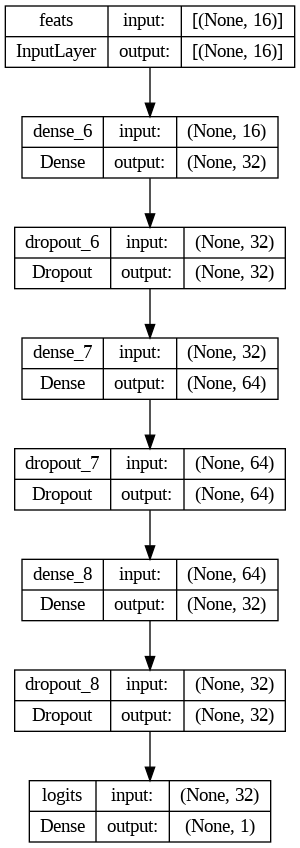

In [ ]:
from keras.utils import plot_model

# 构建模型
model = build_model_4(feature_columns, X_train, y_train)

# 生成模型图并保存到文件
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


# ensemble and predict

# features

In [ ]:
feature_columns = [
    "LH", "FSH", "IGF-1", "IGFBP-3", "GH", "TTE", "PRL", "E2", "Age",
    "BoneAge", "Age_ratio", "uterus1", "uterus2", "uterus3", "lovary1", "lovary2",
    "lovary3", "rovary1", "rovary2", "rovary3", "abnormal", "height", "weight",
    "breast", "core", "vulva", "pubes", "pigmentation", "LH_log", "FSH_log", "IGF-1_log",
    "GH_log", "TTE_log", "PRL_log", "E2_log", "BMI", "Bone_age_diff", "uterus_vol",
    "lovary_vol", "rovary_vol",
    "data_class"]

target_columns = ["IS_CPP"]
data_class = ["data_class"]

feature_columns_SVM = ["LH_log","Age"]
feature_columns_LAB = ["LH_log","Age","LH","FSH","IGF-1","IGFBP-3","GH","TTE","PRL","E2"]
feature_columns_US = ["LH_log","Age", "uterus_vol", "lovary_vol", "rovary_vol",
                   "uterus1", "uterus2", "uterus3",
                   "lovary1", "lovary2", "lovary3",
                   "rovary1", "rovary2", "rovary3",
                   "LH","FSH","IGF-1","IGFBP-3","GH","TTE","PRL","E2"]
feature_columns_BA = ["LH_log","Age", "BoneAge", "Bone_age_diff", "Age_ratio",
                                     "LH","FSH","IGF-1","IGFBP-3","GH","TTE","PRL","E2"]
feature_columns_EMR =  ["LH_log","Age", "abnormal", "breast", "core","vulva","pubes","pigmentation",
                    "LH","FSH","IGF-1","IGFBP-3","GH","TTE","PRL","E2"]


In [ ]:
def data_spilt(X,y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  return X_train, X_test, y_train, y_test

In [ ]:
X = df[feature_columns].values
y = df[target_columns].values

X_train, X_test, y_train, y_test = data_spilt(X,y)

In [ ]:
def selected_feature_of_X_test(data_class):
    if data_class == "LAB":
        selected_features = feature_columns_LAB
    elif data_class == "BA":
        selected_features = feature_columns_BA
    elif data_class == "US":
        selected_features = feature_columns_US
    elif data_class == "EMR":
        selected_features = feature_columns_EMR
    return selected_features

# split_data

In [ ]:
from sklearn.model_selection import train_test_split

# df_SVM為全體資料分割
df_SVM = df
print("SVM:"+str(len(df_SVM)))
X_train_SVM, X_test_SVM, y_train_SVM, y_test_SVM = train_test_split(
    df[selected_feature_of_X_test("LAB")].values,
    df[target_columns].values,
    test_size=0.2,
    random_state=42
)

# df_LAB為
df_LAB = df[df["data_class"] == "LAB"]
print("LAB:"+str(len(df_LAB)))
X_train_LAB, X_test_LAB, y_train_LAB, y_test_LAB = train_test_split(
    df_LAB[selected_feature_of_X_test("LAB")].values,
    df_LAB[target_columns].values,
    test_size=0.2,
    random_state=42
)

# df_BA為
df_BA = df[df["data_class"] == "BA"]
print("BA:"+str(len(df_BA)))
X_train_BA, X_test_BA, y_train_BA, y_test_BA = train_test_split(
    df_BA[selected_feature_of_X_test("BA")].values,
    df_BA[target_columns].values,
    test_size=0.2,
    random_state=42
)
# df_EMR為
df_EMR = df[df["data_class"] == "EMR"]
print("EMR:"+str(len(df_EMR)))
X_train_EMR, X_test_EMR, y_train_EMR, y_test_EMR = train_test_split(
    df[df["data_class"] == "EMR"][selected_feature_of_X_test("EMR")].values,
    df[df["data_class"] == "EMR"][target_columns].values,
    test_size=0.2,
    random_state=42
)
# df_US為
df_US = df[df["data_class"] == "US"]
print("US:"+str(len(df_US)))
X_train_US, X_test_US, y_train_US, y_test_US = train_test_split(
    df_US[selected_feature_of_X_test("US")].values,
    df_US[target_columns].values,
    test_size=0.2,
    random_state=42
)

y_test = np.concatenate((y_test_LAB, y_test_BA, y_test_EMR, y_test_US), axis=0)

SVM:7817
LAB:2523
BA:1612
EMR:1675
US:2007


In [ ]:
X_test_LAB_DNN = X_test_LAB[:, 1:]
X_train_LAB_DNN = X_train_LAB[:, 1:]
X_test_LAB_SVM = X_test_LAB[:, 0:2]

X_test_BA_DNN = X_test_BA[:, 1:]
X_train_BA_DNN = X_train_BA[:, 1:]
X_test_BA_SVM = X_test_BA[:, 0:2]

X_test_EMR_DNN = X_test_EMR[:, 1:]
X_train_EMR_DNN = X_train_EMR[:, 1:]
X_test_EMR_SVM = X_test_EMR[:, 0:2]

X_test_US_DNN = X_test_US[:, 1:]
X_train_US_DNN = X_train_US[:, 1:]
X_test_US_SVM = X_test_US[:, 0:2]

# model_design

In [ ]:
def Calibrated_SVM_LH_log(X_train=X_train_SVM,y_train=y_train_SVM):
    svm_model = SVC(kernel='rbf', class_weight='balanced', probability=True)
    svm_model.fit(X_train, y_train)

    # 使用 CalibratedClassifierCV 进行概率校准
    calibrated_svc = CalibratedClassifierCV(svm_model, method='isotonic', cv='prefit')
    calibrated_svc.fit(X_train, y_train)

    return calibrated_svc

Calibrated_SVM_LH_log()

In [ ]:
def DNN_model_LAB(feature_columns=feature_columns_LAB):
    feature_num = len(feature_columns)
    inputs = layers.Input(shape=(feature_num,), name="feats")

    # 可训练的权重向量
    feature_weights = layers.Dense(feature_num, activation='sigmoid', use_bias=False,
                                   kernel_initializer=initializers.Ones(), name="feature_weights")
    # 权重化输入特征
    weighted_inputs = layers.Multiply()([inputs, feature_weights(inputs)])

    # 后续的全连接层，增加正则化项
    x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.001))(weighted_inputs)
    x = layers.Dropout(0.5)(x)  # 增加Dropout率
    x = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.004))(x)
    x = layers.Dropout(0.3)(x)  # 增加Dropout率
    x = layers.Dense(64, activation="sigmoid", kernel_regularizer=regularizers.l2(0.002))(x)

    # 输出层
    logits = layers.Dense(1, activation='sigmoid', name="logits")(x)  # 因为是二分类问题，所以用 sigmoid

    model = models.Model(inputs=inputs, outputs=logits)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train_LAB_DNN, y_train_LAB, batch_size=8, epochs=200, validation_split=0.2)
    return model

DNN_model_LAB()

Epoch 1/200


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 280, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'model_8' (type Functional).
    
    Input 0 of layer "feature_weights" is incompatible with the layer: expected axis -1 of input shape to have value 9, but received input with shape (None, 1)
    
    Call arguments received by layer 'model_8' (type Functional):
      • inputs=tf.Tensor(shape=(None, 1), dtype=float32)
      • training=True
      • mask=None


In [ ]:
def DNN_model_BA(feature_columns=feature_columns_BA):
    feature_num = len(feature_columns)
    inputs = layers.Input(shape=(feature_num,), name="feats")

    # 可训练的权重向量
    feature_weights = layers.Dense(feature_num, activation='sigmoid', use_bias=False,
                                   kernel_initializer=initializers.Ones(), name="feature_weights")
    # 权重化输入特征
    weighted_inputs = layers.Multiply()([inputs, feature_weights(inputs)])

    # 后续的全连接层，增加正则化项
    x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.001))(weighted_inputs)
    x = layers.Dropout(0.5)(x)  # 增加Dropout率
    x = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.004))(x)
    x = layers.Dropout(0.3)(x)  # 增加Dropout率
    x = layers.Dense(64, activation="sigmoid", kernel_regularizer=regularizers.l2(0.002))(x)

    # 输出层
    logits = layers.Dense(1, activation='sigmoid', name="logits")(x)  # 因为是二分类问题，所以用 sigmoid
    model = models.Model(inputs=inputs, outputs=logits)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train_BA_DNN, y_train_BA, batch_size=8, epochs=200, validation_split=0.2)
    return model

In [ ]:
def DNN_model_EMR(feature_columns=feature_columns_EMR):
    feature_num = len(feature_columns)
    inputs = layers.Input(shape=(feature_num,), name="feats")

    # 可训练的权重向量
    feature_weights = layers.Dense(feature_num, activation='sigmoid', use_bias=False,
                                   kernel_initializer=initializers.Ones(), name="feature_weights")
    # 权重化输入特征
    weighted_inputs = layers.Multiply()([inputs, feature_weights(inputs)])

    # 后续的全连接层，增加正则化项
    x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.001))(weighted_inputs)
    x = layers.Dropout(0.5)(x)  # 增加Dropout率
    x = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.004))(x)
    x = layers.Dropout(0.3)(x)  # 增加Dropout率
    x = layers.Dense(64, activation="sigmoid", kernel_regularizer=regularizers.l2(0.002))(x)

    # 输出层
    logits = layers.Dense(1, activation='sigmoid', name="logits")(x)  # 因为是二分类问题，所以用 sigmoid
    model = models.Model(inputs=inputs, outputs=logits)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train_EMR_DNN, y_train_EMR, batch_size=8, epochs=200, validation_split=0.2)
    return model

In [ ]:
def DNN_model_US(feature_columns=feature_columns_US):
    feature_num = len(feature_columns)
    inputs = layers.Input(shape=(feature_num,), name="feats")

    # 可训练的权重向量
    feature_weights = layers.Dense(feature_num, activation='sigmoid', use_bias=False,
                                   kernel_initializer=initializers.Ones(), name="feature_weights")
    # 权重化输入特征
    weighted_inputs = layers.Multiply()([inputs, feature_weights(inputs)])

    # 后续的全连接层，增加正则化项
    x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.001))(weighted_inputs)
    x = layers.Dropout(0.5)(x)  # 增加Dropout率
    x = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.004))(x)
    x = layers.Dropout(0.3)(x)  # 增加Dropout率
    x = layers.Dense(64, activation="sigmoid", kernel_regularizer=regularizers.l2(0.002))(x)

    # 输出层
    logits = layers.Dense(1, activation='sigmoid', name="logits")(x)  # 因为是二分类问题，所以用 sigmoid
    model = models.Model(inputs=inputs, outputs=logits)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train_US_DNN, y_train_US, batch_size=8, epochs=200, validation_split=0.2)
    return model

# train modle

In [ ]:
trained_model_Calibrated_SVM_LH_log = Calibrated_SVM_LH_log(X_train=X_train_SVM,y_train=y_train_SVM)

#預測結果機率矩陣
y_pred_proba = trained_model_Calibrated_SVM_LH_log.predict_proba(X_test_SVM)
y_pred_proba=y_pred_proba[:,1]
y_pred = trained_model_Calibrated_SVM_LH_log.predict(X_test_SVM)

print(y_pred_proba,y_pred)

#計算accuracy
y_pred_binary = (y_pred_proba > 0.5).astype(int)
accuracy = accuracy_score(y_test_SVM, y_pred)
print("Calibrated_SVM_LH_log"+" Accuracy:", accuracy)

NameError: name 'svm_model' is not defined

In [ ]:
X_train_LAB, X_test_LAB, y_train_LAB, y_test_LAB

In [ ]:
trained_model_DNN_LAB = DNN_model_LAB(df=df_LAB)

#預測結果機率矩陣
y_pred_DNN_LAB = trained_model_DNN_LAB.predict(X_test_LAB)
y_pred_DNN_LAB=y_pred_DNN_LAB[:,0]

print(y_pred_DNN_LAB)

#計算accuracy
y_pred_binary = (y_pred_DNN_LAB > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred_binary)
print("DNN_LAB"+" Accuracy:", accuracy)

In [ ]:
#model 產生
trained_model_DNN_BA = DNN_model_BA(df=filt_df_US)

#預測結果機率矩陣
y_pred_DNN_BA = trained_model_DNN_BA.predict(X_test)
y_pred_DNN_BA=y_pred_DNN_BA[:,0]

print(y_pred_DNN_BA)

#計算accuracy
y_pred_binary = (y_pred_DNN_BA > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred_binary)
print("DNN_BA"+" Accuracy:", accuracy)

In [ ]:
#model 產生
trained_model_DNN_EMR = DNN_model_EMR(df=filt_df_US)

#預測結果機率矩陣
y_pred_DNN_EMR = trained_model_DNN_EMR.predict(X_test)
y_pred_DNN_EMR=y_pred_DNN_EMR[:,0]

print(y_pred_DNN_EMR)

#計算accuracy
y_pred_binary = (y_pred_DNN_EMR > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred_binary)
print("DNN_EMR"+" Accuracy:", accuracy)

In [ ]:
#model 產生
trained_model_DNN_US = DNN_model_US(df=filt_df_US)

#預測結果機率矩陣
y_pred_DNN_US = trained_model_DNN_US.predict(X_test)
y_pred_DNN_US=y_pred_DNN_US[:,0]

print(y_pred_DNN_US)

#計算accuracy
y_pred_binary = (y_pred_DNN_US > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred_binary)
print("DNN_US"+" Accuracy:", accuracy)

# prediction ensemble

In [ ]:
def ensemble_models_for_pred(df):


    # 根据 data_class 选择合适的模型
    y_pred_ensemble = []
#LAB
    X_test_filt = X_test_LAB_DNN
    y_pred_proba_Calibrated_SVM_LH_log = trained_model_Calibrated_SVM_LH_log.predict_proba(X_test_filt)
    y_pred_proba_Calibrated_SVM_LH_log=y_pred_proba_Calibrated_SVM_LH_log[:,1]
    y_pred_model_1 = y_pred_proba_Calibrated_SVM_LH_log

    X_test_filt = X_test_BA
    y_pred_DNN_LAB = trained_model_DNN_LAB.predict(X_test_BA[:, :])
    y_pred_DNN_LAB=y_pred_DNN_LAB[:,0]
    y_pred_model_2 = y_pred_DNN_LAB

    y_pred_ensemble.append(y_pred_model_1)
    y_pred_ensemble.append(np.power(y_pred_model_1 * y_pred_model_2, 1/2))

#BA
    X_test_filt = X_test_BA
    y_pred_proba_Calibrated_SVM_LH_log = trained_model_Calibrated_SVM_LH_log.predict_proba(X_test_BA[:, 0:2])
    y_pred_proba_Calibrated_SVM_LH_log=y_pred_proba_Calibrated_SVM_LH_log[:,1]
    y_pred_model_1 = y_pred_proba_Calibrated_SVM_LH_log

    X_test_filt = X_test_BA
    y_pred_DNN_BA = trained_model_DNN_BA.predict(X_test_BA[:, :])
    y_pred_DNN_BA=y_pred_DNN_BA[:,0]
    y_pred_model_2 = y_pred_DNN_BA

    y_pred_ensemble.append(np.power(y_pred_model_1 * y_pred_model_2, 1/2))
#US
    X_test_filt = X_test_US
    y_pred_proba_Calibrated_SVM_LH_log = trained_model_Calibrated_SVM_LH_log.predict_proba(X_test_BA[:, 0:2])
    y_pred_proba_Calibrated_SVM_LH_log=y_pred_proba_Calibrated_SVM_LH_log[:,1]
    y_pred_model_1 = y_pred_proba_Calibrated_SVM_LH_log

    X_test_filt = X_test_US
    y_pred_DNN_US = trained_model_DNN_US.predict(X_test_BA[:, :])
    y_pred_DNN_US=y_pred_DNN_US[:,0]
    y_pred_model_2 = y_pred_DNN_US

    y_pred_ensemble.append(np.power(y_pred_model_1 * y_pred_model_2, 1/2))
#EMR

    X_test_filt = X_test_EMR
    y_pred_proba_Calibrated_SVM_LH_log = trained_model_Calibrated_SVM_LH_log.predict_proba(X_test_BA[:, 0:2])
    y_pred_proba_Calibrated_SVM_LH_log=y_pred_proba_Calibrated_SVM_LH_log[:,1]
    y_pred_model_1 = y_pred_proba_Calibrated_SVM_LH_log

    X_test_filt = X_test_EMR
    y_pred_DNN_EMR = trained_model_DNN_EMR.predict(X_test_BA[:, :])
    y_pred_DNN_EMR=y_pred_DNN_EMR[:,0]
    y_pred_model_2 = y_pred_DNN_EMR

    y_pred_ensemble.append(np.power(y_pred_model_1 * y_pred_model_2, 1/2))


    y_pred_ensemble,y_test



y_pred_ensemble,y_test = ensemble_models_for_pred(df=df)

#計算accuracy
y_pred_binary = (y_pred_ensemble > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred_binary)
print("Ensemble"+" Accuracy:", accuracy)

InvalidArgumentError: Graph execution error:

Detected at node model_20/feature_weights/MatMul defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-320-729de44e2ee8>", line 53, in <cell line: 53>

  File "<ipython-input-320-729de44e2ee8>", line 19, in ensemble_models_for_pred

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2655, in predict

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py", line 241, in call

Matrix size-incompatible: In[0]: [32,11], In[1]: [13,13]
	 [[{{node model_20/feature_weights/MatMul}}]] [Op:__inference_predict_function_1773055]

In [ ]:
def filt_col(X_test, data_class):
    selected_features = selected_feature_of_X_test(data_class=data_class)
    # 转换为列索引
    col_indices = [feature_columns.index(col) for col in selected_features]
    filt_X_test = X_test[:, col_indices]
    return filt_X_test

def ensemble_models_for_pred(X_test):
    # 根据 data_class 选择合适的模型
    y_pred_ensemble = []
    for i in X_test:
        if i[-1] == "LAB":
            X_test_filt = filt_col(i,"LAB")
            y_pred_proba_Calibrated_SVM_LH_log = trained_model_Calibrated_SVM_LH_log.predict_proba(X_test_filt)
            y_pred_proba_Calibrated_SVM_LH_log=y_pred_proba_Calibrated_SVM_LH_log[:,1]
            y_pred_model_1 = y_pred_proba_Calibrated_SVM_LH_log

            y_pred_ensemble.extend(y_pred_model_1)

        elif i[-1] == "BA":
            X_test_filt = filt_col(i,"LAB")
            y_pred_proba_Calibrated_SVM_LH_log = trained_model_Calibrated_SVM_LH_log.predict_proba(X_test_filt)
            y_pred_proba_Calibrated_SVM_LH_log=y_pred_proba_Calibrated_SVM_LH_log[:,1]
            y_pred_model_1 = y_pred_proba_Calibrated_SVM_LH_log

            X_test_filt = filt_col(i,"BA")
            y_pred_DNN_BA = trained_model_DNN_BA.predict(X_test_filt)
            y_pred_DNN_BA=y_pred_DNN_BA[:,0]
            y_pred_model_2 = y_pred_DNN_BA

            y_pred_ensemble.extend(np.sqrt(y_pred_model_1 * y_pred_model_2))
        elif i[-1] == "US":
            X_test_filt = filt_col(i,"LAB")
            y_pred_proba_Calibrated_SVM_LH_log = trained_model_Calibrated_SVM_LH_log.predict_proba(X_test_filt)
            y_pred_proba_Calibrated_SVM_LH_log=y_pred_proba_Calibrated_SVM_LH_log[:,1]
            y_pred_model_1 = y_pred_proba_Calibrated_SVM_LH_log

            X_test_filt = filt_col(i,"US")
            y_pred_DNN_US = trained_model_DNN_US.predict(X_test_filt)
            y_pred_DNN_US=y_pred_DNN_US[:,0]
            y_pred_model_2 = y_pred_DNN_US

            y_pred_ensemble.extend(np.sqrt(y_pred_model_1 * y_pred_model_2))
        elif i[-1] == "EMR":
            X_test_filt = filt_col(i,"LAB")
            y_pred_proba_Calibrated_SVM_LH_log = trained_model_Calibrated_SVM_LH_log.predict_proba(X_test_filt)
            y_pred_proba_Calibrated_SVM_LH_log=y_pred_proba_Calibrated_SVM_LH_log[:,1]
            y_pred_model_1 = y_pred_proba_Calibrated_SVM_LH_log

            X_test_filt = filt_col(i,"EMR")
            y_pred_DNN_EMR = trained_model_DNN_EMR.predict(X_test_filt)
            y_pred_DNN_EMR=y_pred_DNN_EMR[:,0]
            y_pred_model_2 = y_pred_DNN_EMR

            y_pred_ensemble.extend(np.sqrt(y_pred_model_1 * y_pred_model_2))


    return y_pred_ensemble

y_pred_ensemble = ensemble_models_for_pred(X_test=X_test)

#預測結果機率矩陣
y_pred=y_pred_ensemble[:,0]

print(y_pred)

#計算accuracy
y_pred_binary = (y_pred > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred_binary)
print("Ensemble"+" Accuracy:", accuracy)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

# PCA

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt




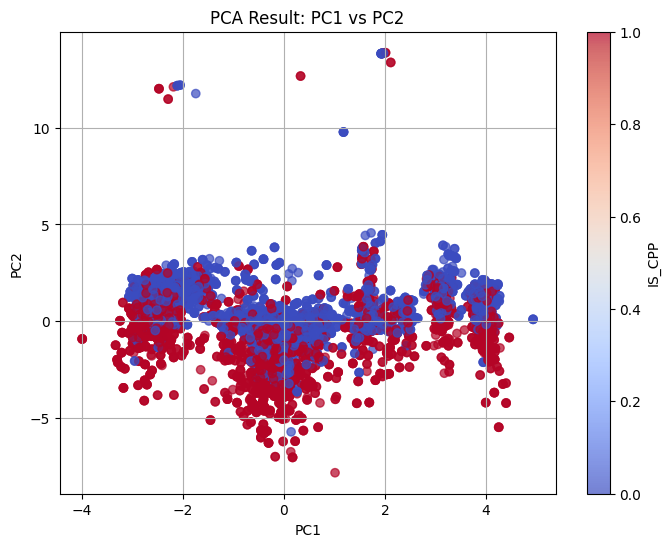

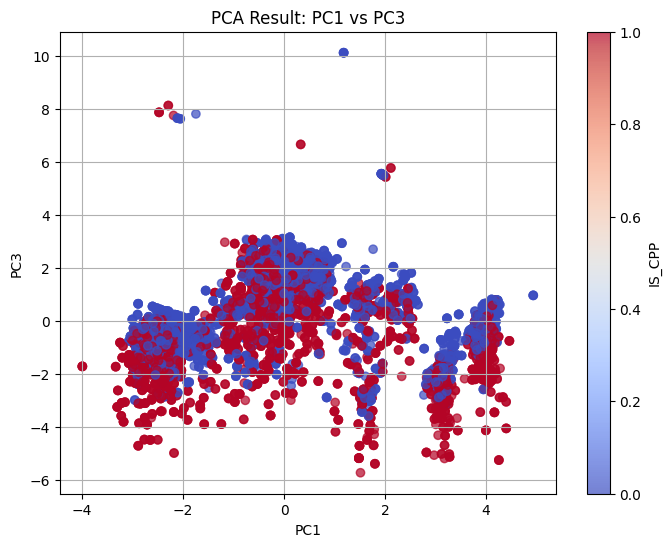

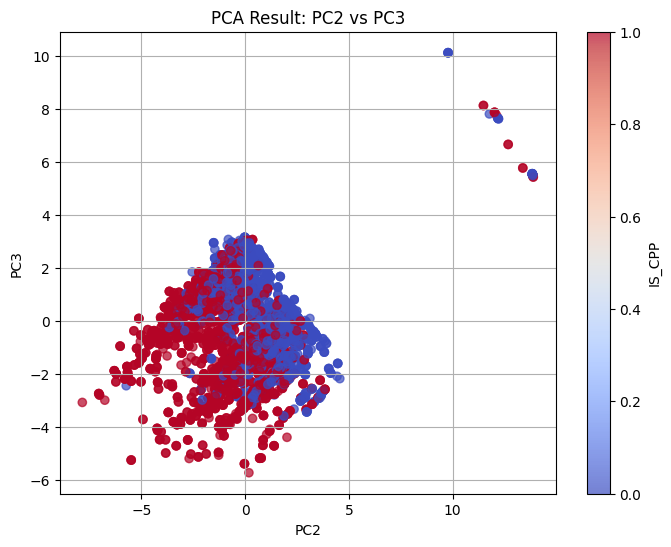

In [ ]:
df_selected = df

feature_columns = [
    "LH", "FSH", "IGF-1", "IGFBP-3", "GH", "TTE", "PRL", "E2", "Age",
    "LH_log", "FSH_log", "IGF-1_log",
    "GH_log", "TTE_log", "PRL_log", "E2_log"]

X = df_selected[feature_columns]

pca = PCA(n_components=3)  #3-dimension
pca_result = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2', 'PC3'])

# 添加 'IS_CPP' 列到 PCA
pca_df['IS_CPP'] = df['IS_CPP']


def plot_pca_components(pca_df, pc_x, pc_y):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(pca_df[pc_x], pca_df[pc_y], c=pca_df['IS_CPP'], cmap='coolwarm', alpha=0.7)
    plt.xlabel(pc_x)
    plt.ylabel(pc_y)
    plt.title(f'PCA Result: {pc_x} vs {pc_y}')
    plt.colorbar(scatter, label='IS_CPP')
    plt.grid(True)
    plt.show()

plot_pca_components(pca_df, 'PC1', 'PC2')
plot_pca_components(pca_df, 'PC1', 'PC3')
plot_pca_components(pca_df, 'PC2', 'PC3')


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# 示例数据
# 假设 pca_df 是您已经进行 PCA 转换后的数据
# 这里用随机生成的示例数据代替
pca_df

# 准备数据
X = pca_df.drop('IS_CPP', axis=1)
y = pca_df['IS_CPP']


# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 创建 KNN 模型，并尝试不同的 K 值
k_values = [1, 3, 5, 7, 9]  # 您可以根据需要选择不同的 K 值
for k in k_values:
    # 创建并训练 KNN 分类器
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    # 在测试集上进行预测
    y_pred = knn.predict(X_test)

    # 计算准确率
    accuracy = accuracy_score(y_test, y_pred)
    print(f'K={k}, Accuracy={accuracy:.2f}')

K=1, Accuracy=0.98
K=3, Accuracy=0.90
K=5, Accuracy=0.84
K=7, Accuracy=0.84
K=9, Accuracy=0.84


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score

pca_df
X = pca_df.drop('IS_CPP', axis=1)
y = pca_df['IS_CPP']


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

accuracies = []
recalls = []
precisions = []

# 不同的 K 值
for k in range(1,6):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)

    accuracies.append(accuracy)
    recalls.append(recall)
    precisions.append(precision)



In [ ]:
for k, (accuracy, recall, precision) in enumerate(zip(accuracies, recalls, precisions), 1):
    print(f"K={k}: Accuracy = {accuracy:.4f}, Recall = {recall:.4f}, Precision = {precision:.4f}")

K=1: Accuracy = 0.9697, Recall = 0.9696, Precision = 0.9651
K=2: Accuracy = 0.9250, Recall = 0.8644, Precision = 0.9700
K=3: Accuracy = 0.8849, Recall = 0.8810, Precision = 0.8714
K=4: Accuracy = 0.8457, Recall = 0.7565, Precision = 0.8932
K=5: Accuracy = 0.8316, Recall = 0.7924, Precision = 0.8348


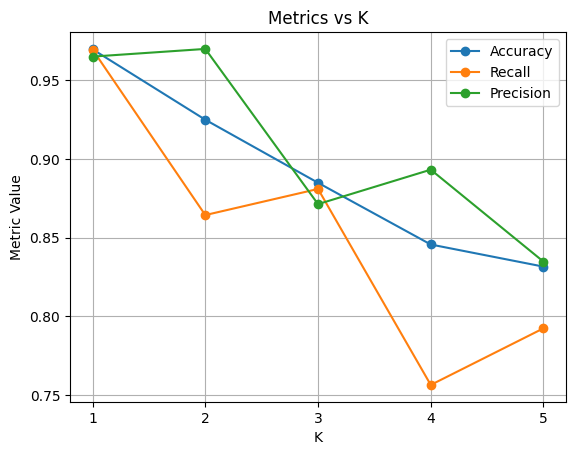

In [ ]:
k_values = range(1, 6)

plt.plot(k_values, accuracies, marker='o', label='Accuracy')
plt.plot(k_values, recalls, marker='o', label='Recall')
plt.plot(k_values, precisions, marker='o', label='Precision')
plt.title('Metrics vs K')
plt.xlabel('K')
plt.ylabel('Metric Value')
plt.xticks(k_values)
plt.legend()
plt.grid(True)
plt.show()


<ipython-input-71-38272e72cde0>:34: RuntimeWarning: divide by zero encountered in log
  log_p_values = np.log(p_values)


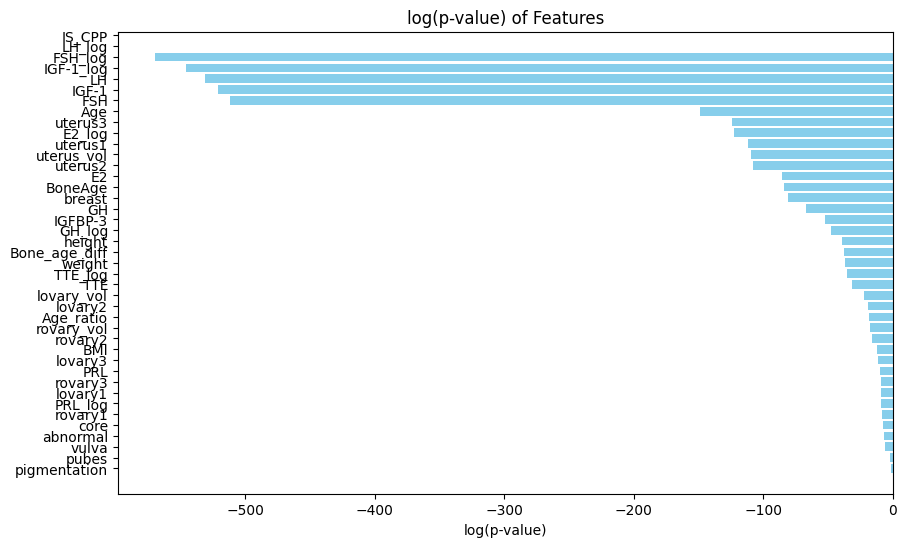

In [ ]:
from scipy import stats

df1=df

import matplotlib.pyplot as plt
import numpy as np
p_values = {}

for column in df1.columns[:-1]:
    filtered_df = df1[df1[column] != -1]

    group1 = filtered_df[filtered_df["IS_CPP"] == 1][column]
    group2 = filtered_df[filtered_df["IS_CPP"] == 0][column]
    t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=False)  # 设置 equal_var=False 表示不假定方差相等
    p_values[column] = p_value


sorted_p_values = sorted(p_values.items(), key=lambda x: x[1])

features = [item[0] for item in sorted_p_values]
p_values = [item[1] for item in sorted_p_values]


log_p_values = np.log(p_values)

plt.figure(figsize=(10, 6))
plt.barh(features, log_p_values, color='skyblue')
plt.xlabel('log(p-value)')
plt.title('log(p-value) of Features')
plt.gca().invert_yaxis()
